# Machine Learning for Reaction Performance Prediction in Allylic Substitution enhanced by Automatic Extraction of Substrate-aware Descriptor

* Author: WANG Xi, YU Gufeng
* Institute: Shanghai Jiao Tong University

Here we will demonstrate the data extraction, data set construction and part of the training process of the model. All the data can be downloaded from our website and GitHub. We are welcome to your valuable suggestions about improving our platform.

## Data Extraction and Preprocessing

The training data are extracted from papers (doi).

### Required packages and functions

Some packages need to be installed before running the code. We have maken the packages require by the code into a virtual environment and uploaded it to GitHub.

In [2]:
import pandas as pd
import numpy as np

We use dataset A for demonstration and first define the path of the dataset. Due to the complexity of the data, we have defined several functions to help obtain information and build the dataset.

The data path is very important, and the parts of the code that involve the path need attention. If you want to process other data sets, you can modify **all paths** according to the actual situation.

In [14]:
path_params = {
    'index_path': './data/data_classA/index.CSV', # Index for the molecules in the dataset (SMILES)
    'CDFT_path': './data/data_classA/CDFT', # Directory of CDFT files
    'gjf_path': './data/data_classA/marked_gjf' # Directory of gjf files
}

#### Function: extra_data

In [15]:
def extra_data(path):
    """
    param path: csv file
    return: SMILES of Nu, Eu, Catalyst, Base and Yield
    """
    df = pd.read_csv(path, encoding='gbk')
    smiles_sub = df['Substrates'].tolist()
    smiles_allyl = df['Allylic Substrates'].tolist()
    cat = df['Catalysts'].tolist()
    base = df['base'].tolist()
    target = df['Yield'].tolist()
    return smiles_sub, smiles_allyl, cat, target, base

#### Function: getName

In [16]:
def getName(smiles, path):
    """
    :param smiles: SMILES of Nu, Eu or Catalyst
    :param path: index file, format=CSV
    :return: The Code of components
    Example:
        smiles = 'O=C(OC/C=C/C1=CC=CC=C1)OC'
        return = E1
    """
    rawdata = pd.read_csv(path)
    par = rawdata[rawdata['SMILES'] == smiles]
    par = par.iloc[:,0]
    parArray = par.values
    x = parArray
    return x[0]

#### Function: block_search
Extract information from "CDFT" files.

In [17]:
import re

def read_file(filename):
    file = pd.read_table(filename)
    file = np.array(file)
    return file.reshape([-1])


def inline_extraction(array):
    '''
    :param string: a list from block extraction
    :return: pure char and float
    '''
    # atom = re.findall('[A-Z]', str(array))
    # print(array)
    play = re.sub('[A-Z]', '', str(array))
    play = re.sub('[a-z]', '', str(play))
    # print(play)
    play = re.sub('\(', '', play)
    play = re.sub('\)', '', play)
    # print(play)
    line = play.split()
    # print(line)
    try:
        temp = [float(x) for x in line]
    except ValueError:
        line[0] = re.sub('[a-z]', '', line[0])
        temp = [float(x) for x in line]
    # Add an atomic type marker at the end of the array with ASCII
    # temp.append(float(ord(atom[0])))
    # print(temp)
    return np.array(temp).reshape([1, -1])


def hartree_extration(array):
    dig = str(array).split(':')
    dig = re.sub('[a-z,A-Z]', '', dig[1])
    dig = re.sub('\^', '', dig)
    temp = [float(x) for x in dig.split()]
    return np.array(temp[0]).reshape([-1])


def data_confusion(raw_data):
    pass


def block_search(file: list):
    '''
    :param file: Pandas.DataFrame
    :return: Crucial Data Block
    Block-1: elementary charge
    Block-2: condensed local electrophilicity/nucleophilicity
    Block-3: condensed local softnesses
    Block-4: non-atomic index data
    '''
    Block = []
    for i in range(4):
        Block.append({'Start': 0, 'End': 0})

    length = len(file)
    Block[3]['End'] = length - 1
    for line in range(length):
        line_str = str(file[line])
        if line_str.find("elementary charge") >= 0:
            Block[0]['Start'] = line + 2

        if line_str.find("Condensed local electrophilicity") >= 0:
            Block[0]['End'] = line - 1
            Block[1]['Start'] = line + 2

        if line_str.find("Condensed local softnesses") >= 0:
            Block[1]['End'] = line - 1
            Block[2]['Start'] = line + 2

        if line_str.find("E(N)") >= 0:
            Block[2]['End'] = line - 1
            Block[3]['Start'] = line

    # check data
    # for i in range(4):
    #     print('Block:{}'.format(i))
    #     for k in range(Block[i]['Start'], Block[i]['End']+1):
    #         print(file[k])

    # DES: descriptor of molecules
    DES = hartree_extration(file[Block[3]['Start']])

    # EC: elementary charge of molecules
    EC = inline_extraction(file[Block[0]['Start']])

    # EN: Condensed local electrophilicity/nucleophilicity index
    EN = inline_extraction(file[Block[1]['Start']])

    # Soft: Condensed local softnesses
    Soft = inline_extraction(file[Block[2]['Start']])

    for i in range(4):
        for k in range(Block[i]['Start'] + 1, Block[i]['End'] + 1):
            if i == 0:
                EC = np.concatenate([EC, inline_extraction(file[k])], axis=0)
                continue
            if i == 1:
                EN = np.concatenate([EN, inline_extraction(file[k])], axis=0)
                continue
            if i == 2:
                Soft = np.concatenate([Soft, inline_extraction(file[k])], axis=0)
                continue
            if i == 3:
                DES = np.concatenate([DES, hartree_extration(file[k])], axis=0)
                continue
    return EC, EN, Soft, DES[3:-1]

#### Function: getAtom

In [18]:
def getAtom(smiles, index_path, CDFT_path, gjf_path):
    """
    :param gjf_path:
    :param index_path:
    :param CDFT_path:
    :param smiles: Nu, Eu
    :return: labeled atoms' index
    We label some atoms with ISO via gauss view
    Example:
        smiles = 'O=C(OC/C=C/C1=CC=CC=C1)OC'
        return = [18, 15, 13, 11]
    """
    Filename = getName(smiles, path=index_path)+ '.gjf'
    path = gjf_path + '/' + Filename
    Atom_Coordinate = read_file(path)
    Label = [0 for x in range(10)]
    Label_Number = 0
    Start_Line = 0

    for count in range(len(Atom_Coordinate)):
        line = Atom_Coordinate[count]
        Atom_Label = line.split()
        if Atom_Label[0] == '0' and Atom_Label[1] == '1':
            Start_Line = count+1
            break

    for count in range(3, len(Atom_Coordinate)):
        line = Atom_Coordinate[count]
        Atom_Label = line.split()
        if Atom_Label[0].find('Iso=') >= 0:
            # print(Atom_Label[0], count-2)
            Label_Number += 1
            number = re.findall('\d', Atom_Label[0])
            Label[int(number[0])] = count-Start_Line

    return Label[1:Label_Number+1]

#### Function: get_Atom_Level; get_Molecule_level

In [19]:
def get_Atom_Level(smiles, index_path, CDFT_path, gjf_path):

    pre_data = read_file(CDFT_path + '/' + getName(smiles, index_path) + '-CDFT.txt')
    EC, EN, Soft, Des = block_search(pre_data)
    Label_Atom_Index = getAtom(smiles, index_path, CDFT_path, gjf_path)

    # Determination of EC, EN and Soft information for Label atoms
    Label_EC = EC[Label_Atom_Index]
    Label_EN = EN[Label_Atom_Index]
    Label_Soft = Soft[Label_Atom_Index]

    # Determining specific information about Label atoms
    Sepcific_EC = Label_EC[:, 4:6]
    # print(Sepcific_EC)
    Sepcific_EN = Label_EN[:, 1:3]
    # print(Sepcific_EN)
    Specific_Soft = Label_Soft[:, 1:4]
    # print(Specific_Soft)

    # Atom-Level Information aggregation
    Atom_Level_Feature = np.concatenate((Sepcific_EC.reshape([-1]), Sepcific_EN.reshape([-1])))
    Atom_Level_Feature = np.concatenate((Atom_Level_Feature, Specific_Soft.reshape([-1])))

    # Return Ndarray
    return Atom_Level_Feature

# def get_Molecule_Level_(smiles, cdft_path = './data/data_classB/CDFT/'):
#     pre_data = read_file(cdft_path + getName(smiles) + '-CDFT.txt')
#     _, _, _, Des = block_search(pre_data)
#     return Des.reshape([-1])

def get_Molecule_Level(smiles, mol_data_path, index_path, CDFT_path, gjf_path):
    rawdata = pd.read_csv(mol_data_path)
    par = rawdata[rawdata['index'] == getName(smiles, path=index_path)]
    par = par.drop(columns='index')
    parArray = par.values
    x = parArray
    return x[0]

In [20]:
print(get_Molecule_Level('O=C(OC/C=C/C1=CC=CC=C1)OC', mol_data_path='./data/data_classB/molecule_data_B.CSV', **path_params))

[-2.93024000e-01  2.83190000e-02  5.12826000e-01  2.36264240e+02
  1.06681451e+03  2.02649898e+03  1.37754945e+00  1.50860000e+02
  1.47880000e+02  4.63200000e-01 -3.64130000e+00  1.05011000e+01
  6.31300000e-01  1.14760000e+00]


#### Function: TempConvert
For solvent, we use pH values as feature. Due to the lack of solvent information in the literature and its high reproducibility, this function and solvent imformation are not used in the final const ructeddataset.

In [21]:
def TempConvert(x):
    if x == "O=P(OO[K])=O.[K][K]":
        return 11.88
    if x == "[O-]C(=O)[O-].[Cs+].[Cs+]":
        return 10.33
    if x == 'CC(N(P1OC2=C(C3=CC=CC=C3C=C2)C4=C5C=CC=CC5=CC=C4O1)C(C6=C7C(C=CC=C7)=CC=C6)C)C8=CC=CC9=C8C=CC=C9':
        return np.array([0, 0, 1])
    if x == 'CC(C1=C(OC)C=CC=C1)N(C(C)C2=CC=CC=C2OC)P3OC4=C(C5=C(C=CC=C6)C6=CC=C5O3)C7=CC=CC=C7C=C4':
        return np.array([0, 1, 0])
    if x == 'CC(C1=CC=CC=C1)N(C(C)C2=CC=CC=C2)P3OC4=C(C5=C(C=CC=C6)C6=CC=C5O3)C7=CC=CC=C7C=C4':
        return np.array([1, 0, 0])

### Making Data Set

In [22]:
data_path = './data/data_classA/Reaction_A.CSV'
print('Extract data from: {}'.format(data_path))
print('Utils from: {}'.format(path_params))
a, b, c, d, e = extra_data(data_path)

Nu_Atom = get_Atom_Level(a[0],**path_params)
Nu_Molecule = get_Molecule_Level(a[0], './data/data_classA/molecule_data_A.CSV', **path_params)
Nu_Feature = np.concatenate((Nu_Atom, Nu_Molecule)).reshape([1, -1])

for i in range(1, len(a)):
    Temp_Atom = get_Atom_Level(a[i],**path_params)
    Temp_Molecule = get_Molecule_Level(a[i], './data/data_classA/molecule_data_A.CSV', **path_params)
    Temp_Feature = np.concatenate((Temp_Atom, Temp_Molecule)).reshape([1, -1])
    Nu_Feature = np.concatenate((Nu_Feature, Temp_Feature), axis=0)

print('Nu Feature shape: ', Nu_Feature.shape)

Eu_Atom = get_Atom_Level(b[0],**path_params)
Eu_Molecule = get_Molecule_Level(b[0], './data/data_classA/molecule_data_A.CSV', **path_params)
Eu_Feature = np.concatenate((Eu_Atom, Eu_Molecule)).reshape([1, -1])

for i in range(1, len(b)):
    Temp_Atom_Eu = get_Atom_Level(b[i],**path_params)
    Temp_Molecule_Eu = get_Molecule_Level(b[i], './data/data_classA/molecule_data_A.CSV', **path_params)
    Temp_Feature_Eu = np.concatenate((Temp_Atom_Eu, Temp_Molecule_Eu)).reshape([1, -1])
    Eu_Feature = np.concatenate((Eu_Feature, Temp_Feature_Eu), axis=0)

print('Eu Feature shape: ', Eu_Feature.shape)
Ligand_Feature = get_Molecule_Level(c[0], './data/data_classA/molecule_data_A.CSV', **path_params).reshape([1, -1])
for i in range(1, len(c)):
    temp = get_Molecule_Level(c[i], './data/data_classA/molecule_data_A.CSV', **path_params).reshape([1, -1])
    Ligand_Feature = np.concatenate((Ligand_Feature, temp), axis=0)


print('Ligand Feature shape: ',Ligand_Feature.shape)

# Solvent_Feature = np.array([TempConvert(x) for x in e])
# Solvent_Feature = Solvent_Feature.reshape([-1, 1])
#
# print('Solvent Feature shape: ',Solvent_Feature.shape)

Extract data from: ./data/data_classA/Reaction_A.CSV
Utils from: {'index_path': './data/data_classA/index.CSV', 'CDFT_path': './data/data_classA/CDFT', 'gjf_path': './data/data_classA/marked_gjf'}
Nu Feature shape:  (69, 49)
Eu Feature shape:  (69, 42)
Ligand Feature shape:  (69, 14)


So far, we have constructed the dataset and printed out the specific information such as the dimension of the dataset. We save it as `feature_A.csv`.

Besides, we can also construct the dataset with other descriptors. We have provided these files formed by different descriptors, the following is the code.

In [42]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.impute import SimpleImputer

def extra_data(path):
    """
    param path: csv file
    return: SMILES of Nu, Eu, Catalyst, Base and Yield
    """
    df = pd.read_csv(path, encoding='gbk')
    smiles_sub = df['Substrates'].tolist()
    smiles_allyl = df['Allylic Substrates'].tolist()
    cat = df['Catalysts'].tolist()
    base = df['base'].tolist()
    target = df['Yield'].tolist()
    return smiles_sub, smiles_allyl, cat, target, base


descriptor_names = [x[0] for x in Descriptors._descList]
descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
def calcuate_fingerprint(smi):
    mol = Chem.MolFromSmiles(smi)

    # 3 descriptors

    # return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)) # Morgan

    # return np.array(list(MACCSkeys.GenMACCSKeys(mol).ToBitString())) # MACCS

    # return np.nan_to_num(np.array(descriptor_calculator.CalcDescriptors(mol))) # ML.Descriptors 0

    return np.array(descriptor_calculator.CalcDescriptors(mol)) # ML.Descriptors mean


data_path = './data/data_classA/Reaction_A.CSV'
a, b, c, d, e = extra_data(data_path)

Nu_Feature = np.array(calcuate_fingerprint(a[0])).reshape([1, -1])

for i in range(1, len(a)):
    Temp_Atom = np.array(calcuate_fingerprint(a[i])).reshape([1, -1])
    Nu_Feature = np.concatenate((Nu_Feature, Temp_Atom), axis=0)

print('Nu Feature shape: ', Nu_Feature.shape)

Eu_Feature = np.array(calcuate_fingerprint(b[0])).reshape([1, -1])

for i in range(1, len(b)):
    Temp_Atom_Eu = np.array(calcuate_fingerprint(b[i])).reshape([1, -1])
    Eu_Feature = np.concatenate((Eu_Feature, Temp_Atom_Eu), axis=0)

print('Eu Feature shape: ',Eu_Feature.shape)

Ligand_Feature = np.array([np.array(calcuate_fingerprint(x)) for x in c])
Ligand_Feature = Ligand_Feature.reshape([len(c), -1])

print('Ligand Feature shape: ', Ligand_Feature.shape)

# Solvent_Feature = np.array([np.array(calcuate_fingerprint(x)) for x in e])
# Solvent_Feature = Solvent_Feature.reshape([len(e), -1])
#
# print('Solvent Feature shape: ',Solvent_Feature.shape)

feature = np.concatenate([Nu_Feature, Eu_Feature, Ligand_Feature], axis=1)
# pd.DataFrame(np.concatenate([feature, np.array(d).reshape([-1, 1])], axis=1)).to_csv('./data/data_classA/data_set/Morgen_feature_A.csv')
# pd.DataFrame(np.concatenate([feature, np.array(d).reshape([-1, 1])], axis=1)).to_csv('./data/data_classA/data_set/MACCS_feature_A.csv')
# pd.DataFrame(np.concatenate([feature, np.array(d).reshape([-1, 1])], axis=1)).to_csv('./data/data_classA/data_set/ML_feature_0_A.csv')
pd.DataFrame(np.concatenate([feature, np.array(d).reshape([-1, 1])], axis=1)).to_csv('./data/data_classA/data_set/ML_feature_mean_A.csv')

Nu Feature shape:  (69, 208)
Eu Feature shape:  (69, 208)
Ligand Feature shape:  (69, 208)


## Model Selection and Evaluation

### Data preprocessing

Before starting to train the model, we get the full data and randomly split the dataset.

In [59]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("./data/data_classA/data_set/feature_A.csv",sep=",")
df = df.drop(columns=df.columns[0])
df_train,df_test = train_test_split(df,test_size=0.2,random_state=1)

### Model Trainning

We use autogluon for model training. Nowdays, autogluon is a well-known AutoML framework that automates model selection and learning optimal parameters. With this framework, we can quickly implement machine learning model fitting and prediction, which will greatly reduce the workload.

In [60]:
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor(label=df_train.columns[-1], problem_type='regression', eval_metric='mean_absolute_error').fit(df_train)

No path specified. Models will be saved in: "AutogluonModels/ag-20220821_163602\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220821_163602\"
AutoGluon Version:  0.5.2
Python Version:     3.8.13
Operating System:   Windows
Train Data Rows:    55
Train Data Columns: 105
Label Column: 105
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    6380.91 MB
	Train Data (Original)  Memory Usage: 0.05 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 14 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting Drop

[1000]	valid_set's l1: 10.0582
[2000]	valid_set's l1: 9.8218
[3000]	valid_set's l1: 9.78241
[4000]	valid_set's l1: 9.75979
[5000]	valid_set's l1: 9.75356
[6000]	valid_set's l1: 9.75198
[7000]	valid_set's l1: 9.75144
[8000]	valid_set's l1: 9.75109
[9000]	valid_set's l1: 9.75097
[10000]	valid_set's l1: 9.75094


	-9.7509	 = Validation score   (-mean_absolute_error)
	2.87s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-7.8117	 = Validation score   (-mean_absolute_error)
	0.26s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 9.52s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220821_163602\")


In [61]:
predictor.leaderboard()

                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -7.811743       0.122669  4.563410                0.000995           0.257312            2       True         12
1         ExtraTreesMSE  -8.600708       0.041888  0.387614                0.041888           0.387614            1       True          7
2               XGBoost  -8.722983       0.006945  0.425896                0.006945           0.425896            1       True          9
3       NeuralNetFastAI  -9.234367       0.067817  0.656213                0.067817           0.656213            1       True          8
4            LightGBMXT  -9.306812       0.003990  0.388961                0.003990           0.388961            1       True          3
5       RandomForestMSE  -9.451504       0.044881  0.634197                0.044881           0.634197            1       True          5
6              CatBoost  -9.652754

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-7.811743,0.122669,4.563410,0.000995,0.257312,2,True,12
1,ExtraTreesMSE,-8.600708,0.041888,0.387614,0.041888,0.387614,1,True,7
2,XGBoost,-8.722983,0.006945,0.425896,0.006945,0.425896,1,True,9
3,NeuralNetFastAI,-9.234367,0.067817,0.656213,0.067817,0.656213,1,True,8
4,LightGBMXT,-9.306812,0.003990,0.388961,0.003990,0.388961,1,True,3
5,RandomForestMSE,-9.451504,0.044881,0.634197,0.044881,0.634197,1,True,5
6,CatBoost,-9.652754,0.003989,1.265306,0.003989,1.265306,1,True,6
7,LightGBMLarge,-9.750939,0.007979,2.873311,0.007979,2.873311,1,True,11
8,NeuralNetTorch,-10.934730,0.039896,1.301516,0.039896,1.301516,1,True,10
9,LightGBM,-10.969554,0.004986,0.290781,0.004986,0.290781,1,True,4


The above is the model training process and the specific performance values of each model. We use the previously divided test set for model validation and visualization.

In [62]:
y_true = df_test.iloc[:, -1]
df_test_non = df_test.drop(columns=df_test.columns[-1])
y_pred = predictor.predict(df_test_non)

Evaluation: mean_absolute_error on test data: -7.605054037911551
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "mean_absolute_error": -7.605054037911551,
    "root_mean_squared_error": -10.42389875557214,
    "mean_squared_error": -108.65766526641839,
    "r2": -0.7223536103694301,
    "pearsonr": 0.07973330243323641,
    "median_absolute_error": -4.459171295166016
}


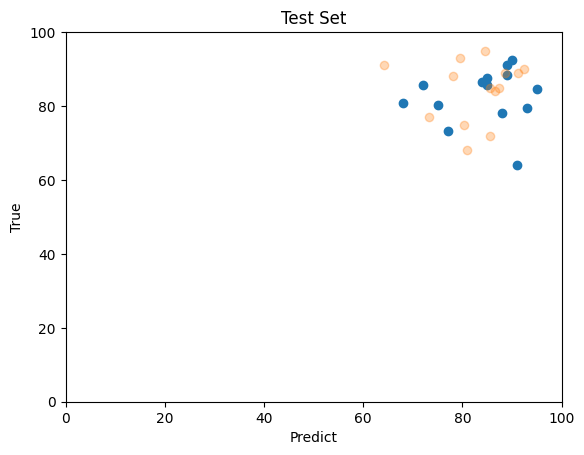

In [63]:
from matplotlib import pyplot as plt
from matplotlib import colors

perf = predictor.evaluate_predictions(y_true=y_true, y_pred=y_pred, auxiliary_metrics=True)
fig = plt.scatter(y_true, y_pred)
changecolor = colors.Normalize(vmin=0.4, vmax=0.8)
plt.scatter(y_pred, y_true, alpha=0.3, cmap='viridis', norm=changecolor)
plt.title('Test Set')
plt.xlabel('Predict')
plt.ylabel('True')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

In [64]:
pd.DataFrame([y_true, y_pred]).to_csv('./pred_A.csv')

## Multi-comparison

In making the dataset, in addition to our descriptors, we also used other descriptors, and here we compare the effects of these descriptors. We use 8 models to train and predict the data formed by the 4 descriptors, and finally conduct a comprehensive comparison of MAE. All models use the original parameters in scikit-learn, and the `random_state` is 42, which objectively forms a unified condition.The performance of the 4 descriptors in the 8 models is stored in the `comparison.csv` and the dimensions of the 4 descriptors are in the `Len_comparison.csv`.

In [43]:
import sklearn.preprocessing as preprocess
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer

path1 = './data/data_classA/data_set/feature_A.csv'
path2 = './data/data_classA/data_set/Morgen_feature_A.csv'
path3 = './data/data_classA/data_set/MACCS_feature_A.csv'
path4 = './data/data_classA/data_set/ML_feature_mean_A.csv'


def eval(reg, feature, target):
    return -cross_val_score(reg, feature, target, cv=5, scoring='neg_mean_absolute_error').mean()


def multiC(*data):
    # fold5 = {
    #     'Elast': [],
    #     'SVR': [],
    #     'Lasso': [],
    #     'RF': [],
    #     'AdaBoost': [],
    #     'ExtraTree': [],
    #     'GBDT': [],
    #     'XgBoost': []
    # }

    Reg1 = ElasticNet(random_state=42)
    Reg2 = SVR()
    Reg3 = Lasso(random_state=42)
    Reg4 = RandomForestRegressor(random_state=42)
    Reg5 = AdaBoostRegressor(random_state=42)
    Reg6 = ExtraTreeRegressor(random_state=42)
    Reg7 = GradientBoostingRegressor(random_state=42)
    Reg8 = XGBRegressor(random_state=42)

    model_list = [Reg1, Reg2, Reg3, Reg4, Reg5, Reg6, Reg7, Reg8]
    SS = preprocess.StandardScaler()
    nanF = SimpleImputer()
    Eval = []
    FeatureL = []

    for data_set in data:
        target = data_set[:, -1]
        feature = data_set[:, 0:-1]
        FeatureL.append(len(feature[0]))
        feature = SS.fit_transform(feature)
        feature = nanF.fit_transform(feature)

        scores = []
        for reg in model_list:
            score = eval(reg, feature, target)
            scores.append(score)
        Eval.append(scores)

    return Eval, FeatureL


if __name__ == '__main__':
    df1 = pd.read_csv(path1, index_col=False).to_numpy()
    df2 = pd.read_csv(path2, index_col=False).to_numpy()
    df3 = pd.read_csv(path3, index_col=False).to_numpy()
    df4 = pd.read_csv(path4, index_col=False).to_numpy()

    Eval, FeatureL = multiC(df1, df2, df3, df4)

    pd.DataFrame(Eval).to_csv('./comparison.csv')
    pd.DataFrame(FeatureL).to_csv('./Len_comparison.csv')

E:\software\anaconda3\envs\chemDL\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.534e+00, tolerance: 1.342e+00
  model = cd_fast.enet_coordinate_descent(
E:\software\anaconda3\envs\chemDL\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e+01, tolerance: 1.261e+00
  model = cd_fast.enet_coordinate_descent(
E:\software\anaconda3\envs\chemDL\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

## Interpretability Analysis

Interpretability is the highlight of our descriptors. To elaborate on this, we train the model on the full dataset and capture the importance of features.

In [65]:
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor(label=df.columns[-1], problem_type='regression', eval_metric='mean_absolute_error').fit(df)

No path specified. Models will be saved in: "AutogluonModels/ag-20220821_163635\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220821_163635\"
AutoGluon Version:  0.5.2
Python Version:     3.8.13
Operating System:   Windows
Train Data Rows:    69
Train Data Columns: 105
Label Column: 105
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    6426.93 MB
	Train Data (Original)  Memory Usage: 0.06 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 14 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting Drop

In [66]:
im = predictor.feature_importance(df, num_shuffle_sets=10)

Computing feature importance via permutation shuffling for 105 features using 69 rows with 10 shuffle sets...
	58.14s	= Expected runtime (5.81s per shuffle set)
	3.78s	= Actual runtime (Completed 10 of 10 shuffle sets)


In [67]:
pd.DataFrame(im).to_csv('./importance.csv')

Using the existing model feature importance data, we draw a heatmap to numerically describe the model and data features. Combined with chemical knowledge, we can analyze the interpretability of the model as well as the descriptors.

In [28]:
from sklearn.preprocessing import MinMaxScaler

df_im = pd.read_csv('./importance.csv')

# Standardization
temp = df_im['p_value'].values
temp = -np.log(temp)
heat = MinMaxScaler().fit_transform(temp.reshape(-1, 1))
df_im['heat'] = heat
df_im.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
df_im

,index,importance,stddev,p_value,n,p99_high,p99_low,heat
0,91,2.433233,0.458695,2.127917e-08,10,2.904628,1.961838,1.000000
1,4,1.084489,0.300453,5.889387e-07,10,1.393262,0.775717,0.812030
2,60,0.825856,0.286275,3.821018e-06,10,1.120058,0.531655,0.706177
3,20,0.577359,0.174661,1.235669e-06,10,0.756856,0.397861,0.770081
4,15,0.543927,0.136587,2.550010e-07,10,0.684296,0.403559,0.859413
...,...,...,...,...,...,...,...,...
100,63,-0.000125,0.000255,9.223489e-01,10,0.000137,-0.000387,0.004575
101,85,-0.000273,0.000785,8.501263e-01,10,0.000534,-0.001081,0.009191
102,40,-0.000668,0.000504,9.988347e-01,10,-0.000150,-0.001186,0.000065
103,53,-0.006983,0.013776,9.282907e-01,10,0.007175,-0.021140,0.004212


Now we can get the importance of each feature dimension and label it. In the following, we analyze the features at the atomic-level and molecular-level respectively.

In [29]:
importance_dict = {}
for i in range(105):
    par = df_im[df_im['index'] == i]
    p_value = par['heat'].values
    dic = {i: p_value[0]}
    print(dic)
    importance_dict.update(dic)

{0: 0.5621715374598864}
{1: 0.47622452272516047}
{2: 0.8385658079989806}
{3: 0.49331151180576005}
{4: 0.8120297367294578}
{5: 0.00036038732206505354}
{6: 0.761760789411257}
{7: 0.6708268622385133}
{8: 0.5182970598623319}
{9: 0.5965630805674317}
{10: 0.47572677835119376}
{11: 0.8036743724317287}
{12: 0.43714352735112677}
{13: 0.646204720946757}
{14: 0.11816687996576283}
{15: 0.8594132389042526}
{16: 0.7116799882569931}
{17: 0.01473011428850735}
{18: 0.20743038137255698}
{19: 0.27522099816832374}
{20: 0.7700810513712574}
{21: 0.5568648809539795}
{22: 0.20510110679130025}
{23: 0.4255868692960513}
{24: 0.6944457198625604}
{25: 0.2801000733532358}
{26: 0.8026738742342305}
{27: 0.235061126199629}
{28: 0.039236651327727856}
{29: 0.039236651327727856}
{30: 0.33929619470918426}
{31: 0.9883014560114108}
{32: 0.33899402270491286}
{33: 0.6532738171304128}
{34: 0.4834590652756653}
{35: 0.3284588919769009}
{36: 0.2610734291093507}
{37: 0.8724090243771041}
{38: 0.4577986124650936}
{39: 0.252764173911

In [39]:
Nu = [x for x in range(0, 35)]
E = [x for x in range(49, 77)]
M_Nu = [x for x in range(35, 49)]
M_E = [x for x in range(77, 91)]
atom = np.concatenate([np.array(Nu, dtype=np.float64), np.array(E, dtype=np.float64)])
molecule = np.concatenate([np.array(M_Nu, dtype=np.float64), np.array(M_E, dtype=np.float64)])
for i in range(len(atom)):
    atom[i] = importance_dict[atom[i]]
    # atom[i] = -math.log(atom[i], math.e)
for i in range(len(molecule)):
    molecule[i] = importance_dict[molecule[i]]
    # molecule[i] = -math.log(molecule[i], math.e)

atom = atom.reshape([9, 7])
molecule = molecule.reshape([2, -1])

Atom = pd.DataFrame(atom, columns=['f-', 'f+', 'EI', 'NuI', 's-', 's+', 's0'], index=['Nu-Atom1', 'Nu-Atom2', 'Nu-Atom3', 'Nu-Atom4', 'Nu-Atom5', 'E-Atom1', 'E-Atom2', 'E-Atom3', 'E-Atom4'])
Molecule = pd.DataFrame(molecule, columns=['HOMO', 'LUMO', 'MMDM', 'MW', 'SA', 'Volume', 'Ovality', 'PSA', 'NPSA', 'MPI', 'CP', 'Hardness', 'EI', 'NI'], index=['Nu', 'E'])

In [40]:
Atom

,f-,f+,EI,NuI,s-,s+,s0
Nu-Atom1,0.562172,0.476225,0.838566,0.493312,0.812030,0.000360,0.761761
Nu-Atom2,0.670827,0.518297,0.596563,0.475727,0.803674,0.437144,0.646205
Nu-Atom3,0.118167,0.859413,0.711680,0.014730,0.207430,0.275221,0.770081
Nu-Atom4,0.556865,0.205101,0.425587,0.694446,0.280100,0.802674,0.235061
Nu-Atom5,0.039237,0.039237,0.339296,0.988301,0.338994,0.653274,0.483459
E-Atom1,0.100545,0.596256,0.129362,0.132135,0.004212,0.393960,0.039237
E-Atom2,0.052976,0.490767,0.039237,0.534472,0.706177,0.757967,0.194950
E-Atom3,0.004575,0.329404,0.039237,0.316182,0.011624,0.224388,0.244231
E-Atom4,0.039237,0.084989,0.416301,0.413896,0.670468,0.708358,0.399003


In [41]:
Molecule

,HOMO,LUMO,MMDM,MW,SA,Volume,Ovality,PSA,NPSA,MPI,CP,Hardness,EI,NI
Nu,0.328459,0.261073,0.872409,0.457799,0.252764,0.000065,0.874181,0.759048,0.705012,0.228681,0.377800,0.794508,0.638582,0.429855
E,0.397637,0.095684,0.461041,0.219273,0.039237,0.042183,0.000000,0.040320,0.009191,0.102141,0.227701,0.945810,0.127983,0.359338


### Visualization

In [33]:
import seaborn as sns
from matplotlib import pyplot as plt

def ShowGRAHeatMap(DataFrame):
    colormap = plt.cm.hsv
    ylabels = DataFrame.columns.values.tolist()
    f, ax = plt.subplots(figsize=(30, 30))
    # ax.set_title('Feature Importance via Converted p-values')


    with sns.axes_style("white"):
        sns.heatmap(DataFrame,
                    cmap="YlGnBu",
                    annot=True,
                    annot_kws={"fontsize":42}
                    )
    # colorbar
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=36)  # colorbar fontsize
    plt.tick_params(labelsize=36)
    plt.savefig('atom_figure.png',dpi=400)
    plt.show()

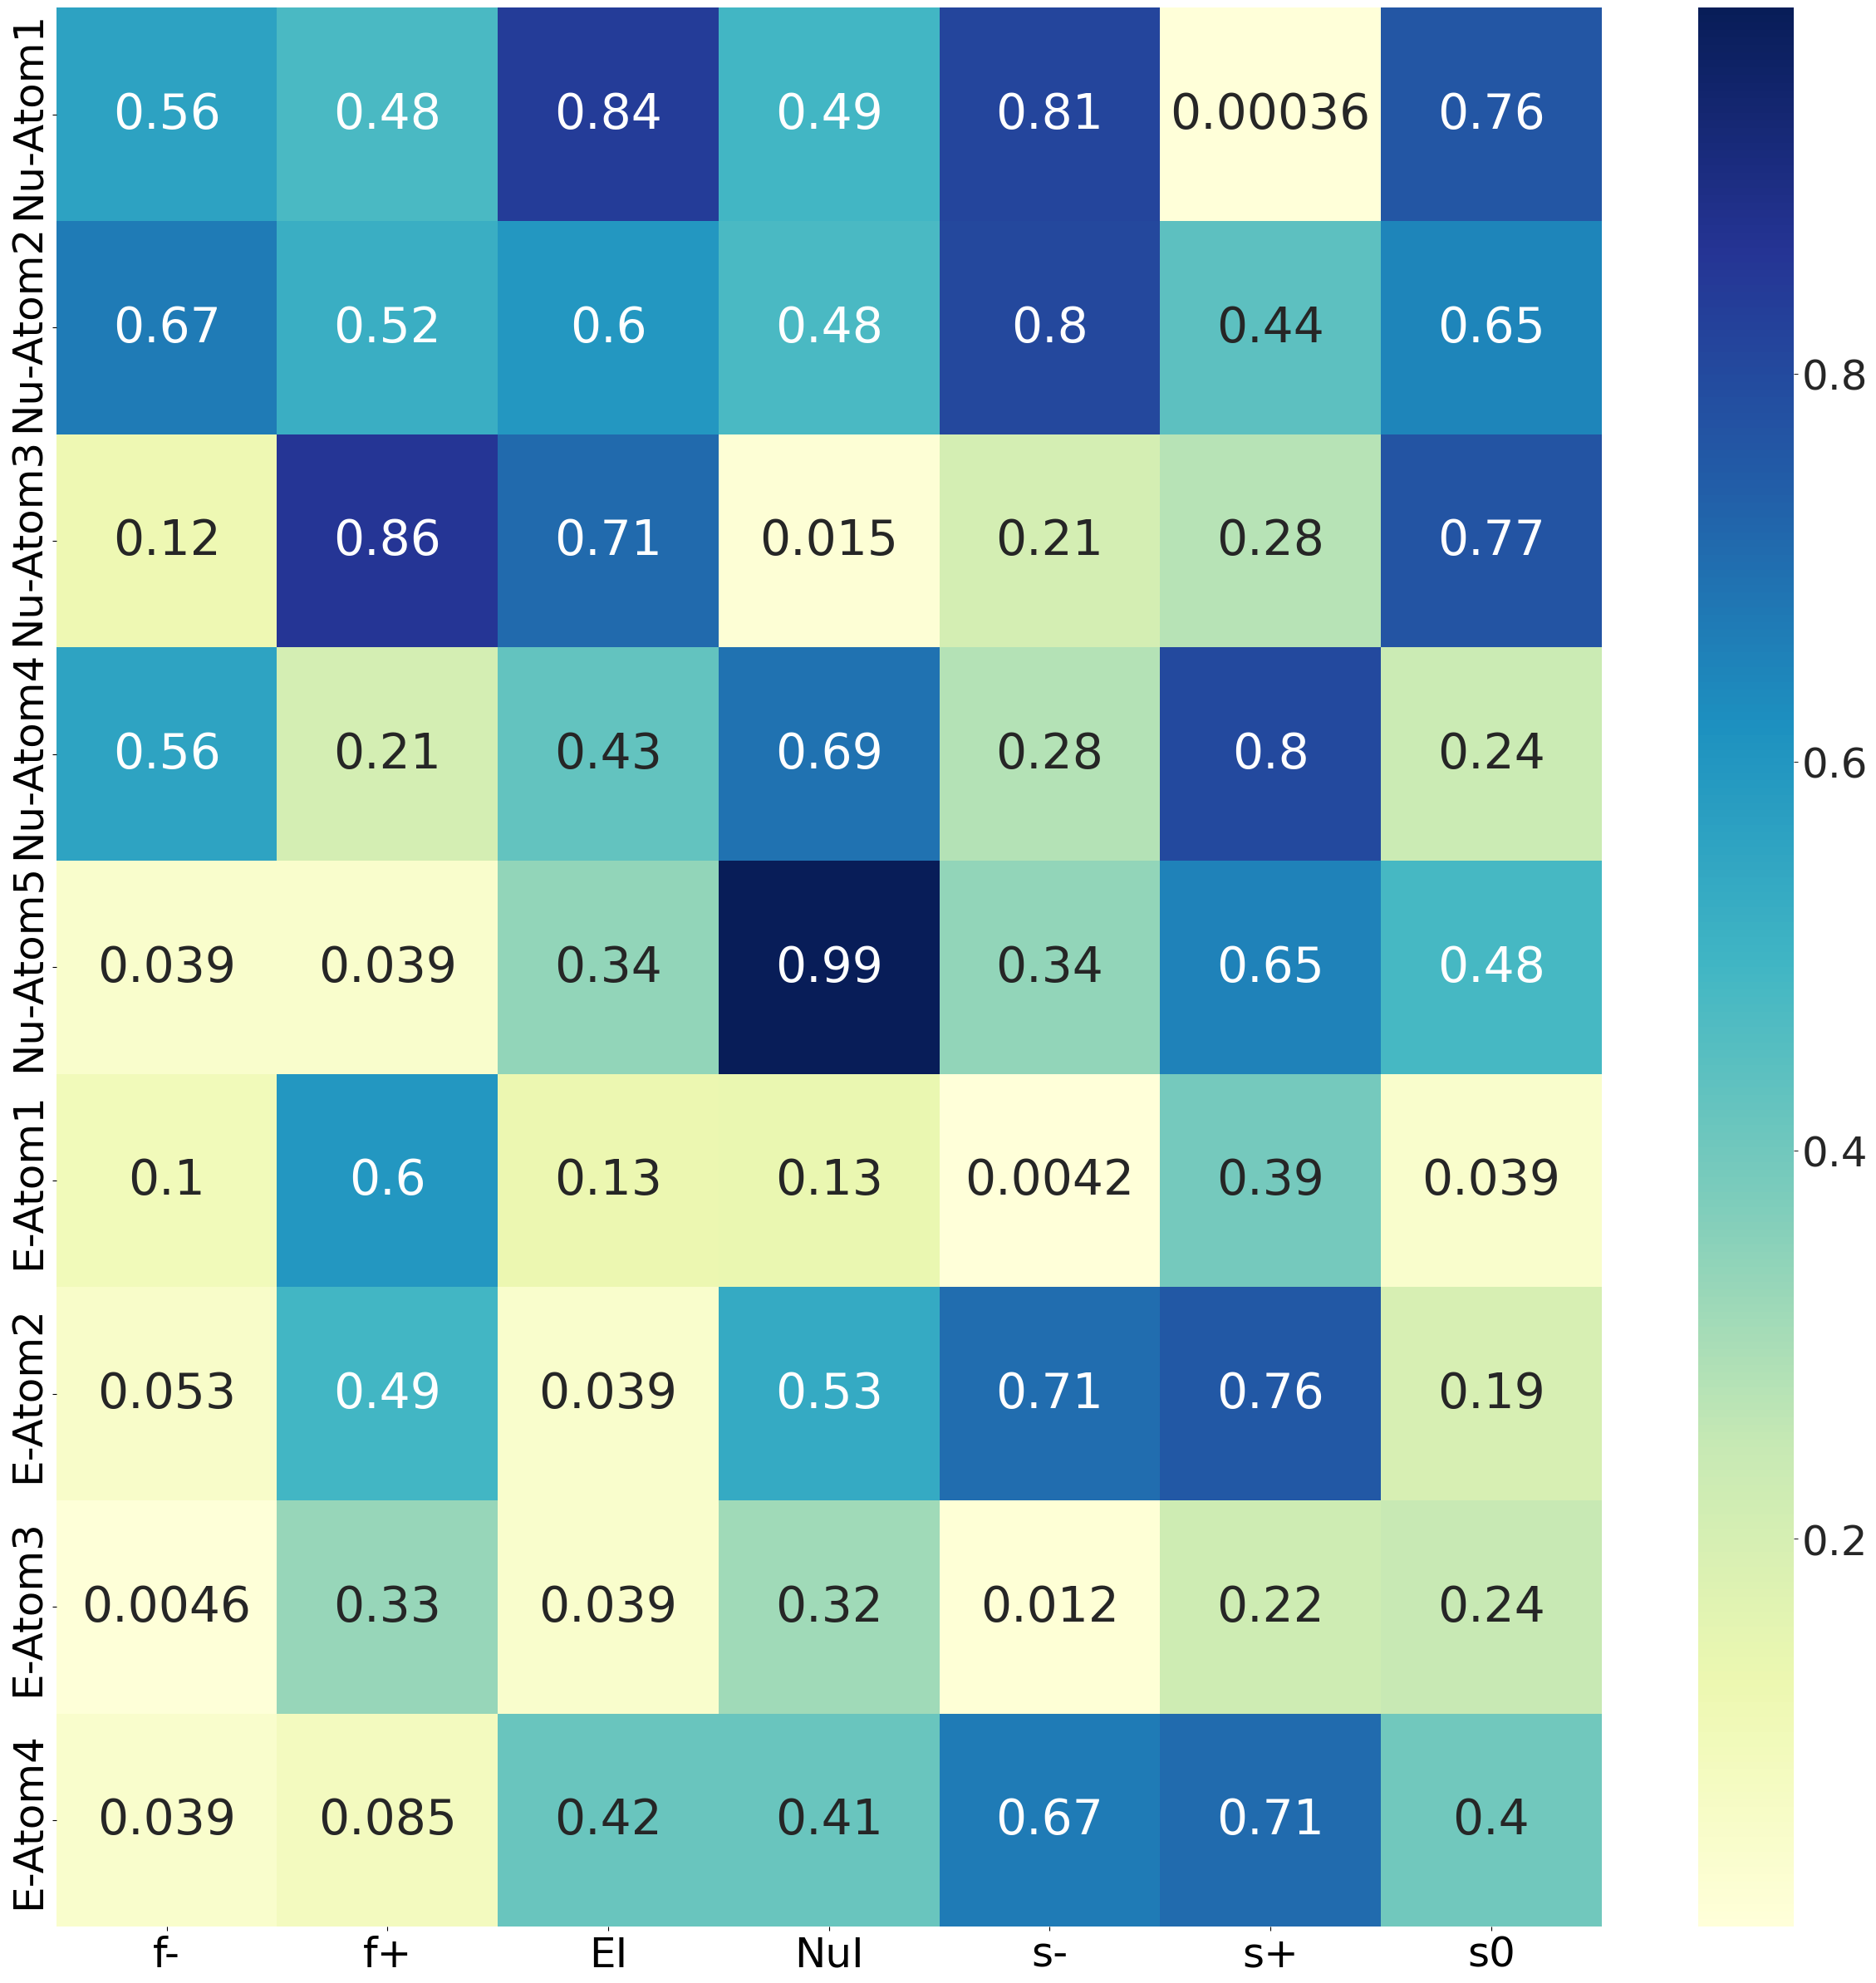

In [34]:
ShowGRAHeatMap(Atom)

In [35]:
import seaborn as sns
from matplotlib import pyplot as plt

def ShowGRAHeatMap(DataFrame):
    colormap = plt.cm.hsv
    ylabels = DataFrame.columns.values.tolist()
    f, ax = plt.subplots(figsize=(35, 2))
    # ax.set_title('Feature Importance via Converted p-values')


    with sns.axes_style("white"):
        sns.heatmap(DataFrame,
                    cmap="YlGnBu",
                    annot=True,
                    annot_kws={"fontsize":24}
                    )
    # colorbar
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=36)  # colorbar fontsize
    plt.tick_params(labelsize=26)
    plt.savefig('mol_figure.png',dpi=400)
    plt.show()

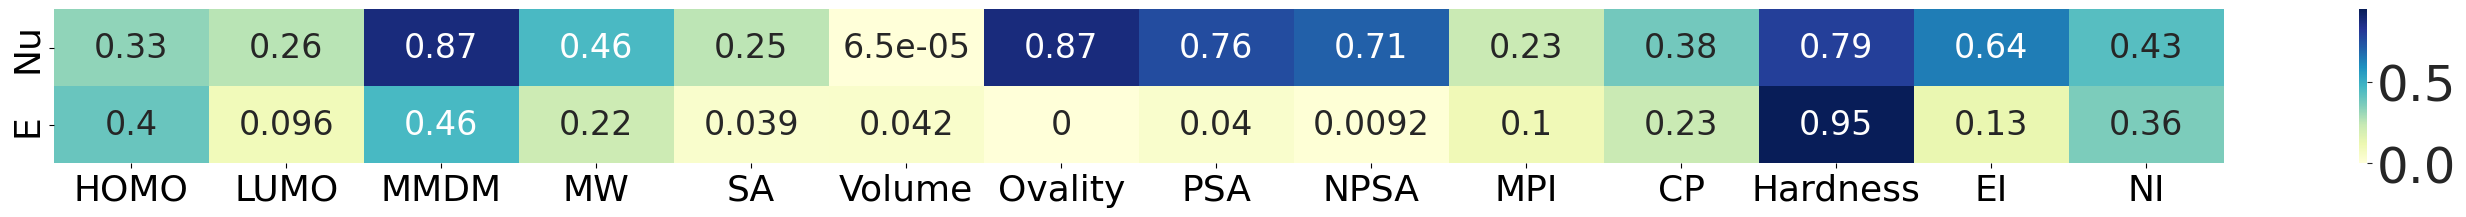

In [36]:
ShowGRAHeatMap(Molecule)

## Tools

In addition to the above pipeline, we also use some other tools for data cleaning and dataset construction.

### FindMCS

Before performing calculations in computational chemistry, we need to determine the atoms and groups in the molecule. The key atoms in the molecule often dominate the performance of reactions, so it is very important to identify the key atoms.

We perform a maximum common substructure search on the A dataset. In total, we analyzed 69 reactions and obtained the largest common substructure of nucleophiles and electrophiles.

In [4]:
from rdkit.Chem import rdFMCS
from rdkit import Chem

def FindSub(mols):
    nums = len(mols)
    for i in range(nums):
        mols[i] = Chem.MolFromSmiles(mols[i])
        if mols[i] == None:
            print(i)

    res = rdFMCS.FindMCS(mols, atomCompare=rdFMCS.AtomCompare.CompareAny)
    common = Chem.MolFromSmarts(res.smartsString)

    return res, common

rawData = pd.read_csv('./data/data_classA/Reaction_A.CSV')
cat1 = rawData.iloc[:, 0]
cat2 = rawData.iloc[:, 1]
cat1 = cat1.tolist()
cat2 = cat2.tolist()

res1, common1 = FindSub(cat1)
res2, common2 = FindSub(cat2)

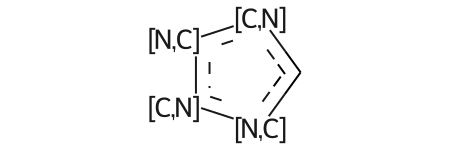

In [5]:
common1

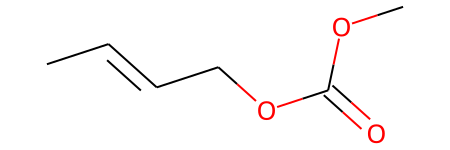

In [6]:
common2

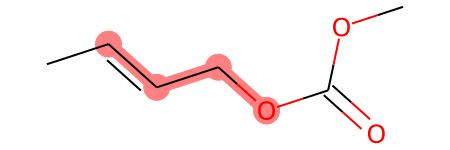

In [43]:
patt = Chem.MolFromSmarts('C=CCO') # add color
atomids = common2.GetSubstructMatch(patt)
common2

### Script: Get Molecule data

When making data set, we read `molecule_data_A.CSV` directly and obtained information at the molecular level. In fact, these data are extracted from "CDFT" files and "MPI" files. Below is the code of the script, you can save it as a `.py` file and use it in the command.

In [ ]:
#!/usr/bin/python

import os
import numpy as np
import pandas as pd
import math
import argparse

def modifyFile(path):
    # Modify spaces in a file
    f_new = open(path + '.new', 'w')
    with open(path) as f:
        line = f.readline()
        while line:
            line = line.replace("   ", ' ')
            line = line.replace("  ", ' ')
            f_new.write(line)
            line = f.readline()

def getLog_inf(logfile):
    # Extract valid information from each log file
    rawdata = pd.read_csv(logfile, header=None, sep=' ')
    numdata = rawdata.iloc[:, 1].values
    numdata = numdata.tolist()
    nameindex = rawdata.iloc[:, 0].values
    nameindex = nameindex.tolist()
    return numdata, nameindex

def getDir(path, dataful):
    # Read .log file by directory
    filelist = os.listdir(path)
    for file in filelist:
        file_path = os.path.join(path, file)
        if os.path.splitext(file_path)[1]=='.log':
            # modifyFile(file_path)
            # file_path_new = file_path + '.new'
            # numdata, nameindex = getLog_inf(file_path_new)
            numdata, nameindex = getLog_inf(file_path)
            dataname = os.path.splitext(file)[0]
            chooseColumn(dataname, numdata, dataful)

    for i in range(len(nameindex)):
        nameindex[i] = nameindex[i].replace('.txt', '')
    dataful.loc[:, 'index'] = nameindex

def chooseColumn(columnName, data, dataful):
    columnDict = {'HOMO': 'EHOMO(a.u.)',
                  'LUMO': 'ELUMO(a.u.)',
                  'dipole': 'Magnitude of molecular dipole moment(a.u.)',
                  'MW': 'Molecular Weight',
                  'Surface': 'Surface Area (Bohr^2)',
                  'Volume': 'Volume (Bohr^3)',
                  'Polar-Surface': 'Polar Surface Area (Angstrom^2)',
                  'Nonpolar-Surface': 'Non-Polar Surface Area (Angstrom^2)',
                  'MPI': 'MPI index (eV)',
                  'Chemical-potential': 'Chemical potential (eV)',
                  'Hardness': 'Hardness (eV)',
                  'Electrophilicity-index': 'Electrophilicity index (eV)',
                  'Nucleophilicity-index': 'Nucleophilicity index (eV)'}
    index = columnDict[columnName]
    dataful.loc[:, index] = data


def getArg():
    parser = argparse.ArgumentParser(description='Script argparse setting')
    parser.add_argument('-c', dest='CDFT', default='./CDFT', help='Path to CDFT folder, default is ./CDFT')
    parser.add_argument('-m', dest='MPI', default='./MPI', help='Path to MPI folder, default is ./MPI')
    parser.add_argument('-o', dest='output', default='./mol_data.csv', help='Path to output file, default is ./mol_data.csv')
    args = parser.parse_args()
    CDFT, MPI, output = args.CDFT, args.MPI, args.output

    return CDFT, MPI, output

def grepInf(path, type='CDFT'):
    if type == 'CDFT':
        log1 = open(path + '/Chemical-potential.log', 'w')
        log2 = open(path + '/Electrophilicity-index.log', 'w')
        log3 = open(path + '/Hardness.log', 'w')
        log4 = open(path + '/Nucleophilicity-index.log', 'w')

        filelist = os.listdir(path)
        for file in filelist:
            file_path = os.path.join(path, file)
            if os.path.splitext(file_path)[1] == '.txt':
                with open(file_path) as f:
                    line = f.readline()
                    while line:
                        if ' Chemical potential:' in line:
                            result1 = (line[53:].strip()).replace('\n', '')
                        elif ' Electrophilicity index:' in line:
                            result2 = (line[49:].strip()).replace('\n', '')
                        elif ' Hardness (=fundamental gap):' in line:
                            result3 = (line[53:].strip()).replace('\n', '')
                        elif ' Nucleophilicity index:' in line:
                            result4 = (line[48:].strip()).replace('\n', '')

                        line = f.readline()

                log1.write(file.replace('CDFT_', '') + ' ' + result1 + '\n')
                log2.write(file.replace('CDFT_', '') + ' ' + result2 + '\n')
                log3.write(file.replace('CDFT_', '') + ' ' + result3 + '\n')
                log4.write(file.replace('CDFT_', '') + ' ' + result4 + '\n')

        log1.close()
        log2.close()
        log3.close()
        log4.close()


    elif type == 'MPI':
        log1 = open(path + '/dipole.log', 'w')
        log2 = open(path + '/HOMO.log', 'w')
        log3 = open(path + '/LUMO.log', 'w')
        log4 = open(path + '/MPI.log', 'w')
        log5 = open(path + '/MW.log', 'w')
        log6 = open(path + '/Nonpolar-Surface.log', 'w')
        log7 = open(path + '/Polar-Surface.log', 'w')
        log8 = open(path + '/Surface.log', 'w')
        log9 = open(path + '/Volume.log', 'w')

        filelist = os.listdir(path)
        for file in filelist:
            file_path = os.path.join(path, file)
            if os.path.splitext(file_path)[1] == '.txt':
                with open(file_path) as f:
                    line = f.readline()
                    while line:
                        if ' Magnitude of molecular dipole moment (a.u.&Debye):' in line:
                            result1 = (line[56:67].strip()).replace('\n', '')
                        elif 'HOMO, energy:' in line:
                            result2 = (line[40:56].strip()).replace('\n', '')
                        elif 'LUMO, energy:' in line:
                            result3 = (line[40:56].strip()).replace('\n', '')
                        elif ' Molecular polarity index (MPI):' in line:
                            result4 = (line[34:42].strip()).replace('\n', '')
                        elif ' Molecule weight:' in line:
                            result5 = (line[23:36].strip()).replace('\n', '')
                        elif ' Nonpolar surface area (|ESP| <= 10 kcal/mol):' in line:
                            result6 = (line[49:68].strip()).replace('\n', '')
                        elif ' Polar surface area (|ESP| > 10 kcal/mol):' in line:
                            result7 = (line[49:68].strip()).replace('\n', '')
                        elif ' Overall surface area:' in line:
                            result8 = (line[30:49].strip()).replace('\n', '')
                        elif ' Volume:' in line:
                            result9 = (line[9:28].strip()).replace('\n', '')

                        line = f.readline()

                log1.write(file + ' ' + result1 + '\n')
                log2.write(file + ' ' + result2 + '\n')
                log3.write(file + ' ' + result3 + '\n')
                log4.write(file + ' ' + result4 + '\n')
                log5.write(file + ' ' + result5 + '\n')
                log6.write(file + ' ' + result6 + '\n')
                log7.write(file + ' ' + result7 + '\n')
                log8.write(file + ' ' + result8 + '\n')
                log9.write(file + ' ' + result9 + '\n')

        log1.close()
        log2.close()
        log3.close()
        log4.close()
        log5.close()
        log6.close()
        log7.close()
        log8.close()
        log9.close()



def main(CDFT, MPI, output):
    """
    :param CDFT: Directory of CDFT files
    :param MPI: Directory of CDFT files
    :param output: Path of output file
    :return:
    """
    dataFul = pd.DataFrame(columns=['index',
                                    'EHOMO(a.u.)',
                                    'ELUMO(a.u.)',
                                    'Magnitude of molecular dipole moment(a.u.)',
                                    'Molecular Weight',
                                    'Surface Area (Bohr^2)',
                                    'Volume (Bohr^3)',
                                    'Ovality',
                                    'Polar Surface Area (Angstrom^2)',
                                    'Non-Polar Surface Area (Angstrom^2)',
                                    'MPI index (eV)',
                                    'Chemical potential (eV)',
                                    'Hardness (eV)',
                                    'Electrophilicity index (eV)',
                                    'Nucleophilicity index (eV)'])

    getDir(CDFT, dataFul)
    getDir(MPI, dataFul)

    Ovality = dataFul.loc[:, 'Surface Area (Bohr^2)'].values/(4*math.pi*(3*dataFul.loc[:, 'Volume (Bohr^3)'].values/4/math.pi)**(2/3))
    dataFul.loc[:, 'Ovality'] = Ovality.tolist()
    dataFul.to_csv(output, index=False)


CDFT, MPI, output = getArg()
grepInf(CDFT, 'CDFT')
grepInf(MPI, 'MPI')
main(CDFT, MPI, output)
print("complited!")